# Image Captioning with Transformers

In [1]:
!nvidia-smi

Fri Jun 25 00:38:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!apt install -qq fuse-zip

The following additional packages will be installed:
  libzip4
The following NEW packages will be installed:
  fuse-zip libzip4
0 upgraded, 2 newly installed, 0 to remove and 39 not upgraded.
Need to get 65.6 kB of archives.
After this operation, 178 kB of additional disk space will be used.
Selecting previously unselected package libzip4:amd64.
(Reading database ... 160772 files and directories currently installed.)
Preparing to unpack .../libzip4_1.1.2-1.1_amd64.deb ...
Unpacking libzip4:amd64 (1.1.2-1.1) ...
Selecting previously unselected package fuse-zip.
Preparing to unpack .../fuse-zip_0.4.4-1_amd64.deb ...
Unpacking fuse-zip (0.4.4-1) ...
Setting up libzip4:amd64 (1.1.2-1.1) ...
Setting up fuse-zip (0.4.4-1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Processing triggers for libc-bin (2.27-3ubuntu1.2) ...
/sbin/ldconfig.real: /usr/local/lib/python3.7/dist-packages/ideep4py/lib/libmkldnn.so.0 is not a symbolic link



In [3]:
%pip install -q timm wandb

     |████████████████████████████████| 348kB 7.4MB/s 
     |████████████████████████████████| 1.8MB 13.6MB/s 
     |████████████████████████████████| 174kB 46.8MB/s 
     |████████████████████████████████| 133kB 36.1MB/s 
     |████████████████████████████████| 102kB 12.8MB/s 
     |████████████████████████████████| 71kB 10.3MB/s 


In [4]:
!git clone https://github.com/ShivamShrirao/Image-Captioning-Transformers

Cloning into 'Image-Captioning-Transformers'...
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 28 (delta 7), reused 26 (delta 5), pack-reused 0
Unpacking objects: 100% (28/28), done.


# Download Dataset and Annotations

In [5]:
from torchvision.datasets.utils import download_url, download_and_extract_archive

In [6]:
DATA_DIR = "datasets/COCO"

In [7]:
download_url("http://images.cocodataset.org/zips/train2017.zip", root=DATA_DIR)

# Extract data in limited space

In [8]:
import glob
import shutil
from tqdm.auto import tqdm

In [9]:
!mkdir datasets/COCO/mnt
!mkdir -p /content/ramdisk/
!mount -t tmpfs -o size=10240M tmpfs /content/ramdisk

In [10]:
!fuse-zip datasets/COCO/train2017.zip datasets/COCO/mnt/
files = glob.glob("datasets/COCO/mnt/train2017/*")

for f in tqdm(files[:int(len(files)*0.5)]):
    shutil.move(f, "/content/ramdisk")

!fusermount -u datasets/COCO/mnt

In [11]:
# Wait for it to write changes to zip

In [12]:
# now unzip the smaller leftover zip
!7z x datasets/COCO/train2017.zip -o./datasets/COCO/


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 9671849471 bytes (9224 MiB)

Extracting archive: datasets/COCO/train2017.zip
  6% 4096 Open              --
Path = datasets/COCO/train2017.zip
Type = zip
Physical Size = 9671849471
64-bit = +

  0%      0% 60 - train2017/000000574138.jpg                                      0% 98 - train2017/000000532520.jpg                                      0% 140 - train2017/000000443278.jpg                                       0% 182 - train2017/000000456863.jpg

In [13]:
!rm datasets/COCO/train2017.zip
!rm -r datasets/COCO/mnt

In [14]:
ram_files = glob.glob("/content/ramdisk/*")
for f in tqdm(ram_files):
    shutil.move(f, "datasets/COCO/train2017")

In [17]:
!umount /content/ramdisk
!rm -r /content/ramdisk

# Download rest of files

In [18]:
# download_and_extract_archive("http://images.cocodataset.org/zips/val2017.zip",
#                              download_root=DATA_DIR,
#                              remove_finished=True)


Extracting datasets/COCO/val2017.zip to datasets/COCO


In [20]:
# download_and_extract_archive("http://images.cocodataset.org/annotations/annotations_trainval2017.zip",
#                              download_root=DATA_DIR,
#                              remove_finished=True)


Extracting datasets/COCO/annotations_trainval2017.zip to datasets/COCO


In [21]:
# !rm datasets/COCO/val2017.zip datasets/COCO/annotations_trainval2017.zip

# Import libraries

In [22]:
%cd Image-Captioning-Transformers

/content/Image-Captioning-Transformers


In [23]:
#hide
%load_ext autoreload
%autoreload 2

In [24]:
# TODO: Try pre trained CLIP

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision import datasets, transforms as T

In [26]:
import math
from random import randint
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from collections import OrderedDict

In [27]:
import timm

In [28]:
plt.rcParams['figure.facecolor'] = 'white'

# Preprocessing Transforms

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [30]:
input_size = 224

In [31]:
preproc = {
    'train': T.Compose([
        T.RandomResizedCrop(input_size, interpolation=T.InterpolationMode.BICUBIC),
        T.RandomHorizontalFlip(input_size),
        lambda image: image.convert("RGB"),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    'val': T.Compose([
        T.Resize(input_size, interpolation=T.InterpolationMode.BICUBIC),
        T.CenterCrop(input_size),
        lambda image: image.convert("RGB"),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Dataset utils

In [32]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import torchtext

## Read COCO dataset

In [33]:
DATA_DIR = "../datasets/COCO/"

In [34]:
train_data = datasets.CocoCaptions(root=DATA_DIR+"/train2017/",
                                   annFile=DATA_DIR+"/annotations/captions_train2017.json",
                                   transform=preproc['train'])

val_data = datasets.CocoCaptions(root=DATA_DIR+"/val2017/",
                                 annFile=DATA_DIR+"/annotations/captions_val2017.json",
                                 transform=preproc['val'])

loading annotations into memory...
Done (t=0.96s)
creating index...
index created!
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


## Tokenizer and Build Vocab

In [35]:
tokenizer = get_tokenizer('basic_english')

In [36]:
def yield_tokens(cap_data):
    for ann in cap_data.coco.anns.values():
        yield tokenizer(ann['caption'])

In [37]:
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']
en_vocab = build_vocab_from_iterator(yield_tokens(train_data), specials=special_symbols, special_first=True)

UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = en_vocab(special_symbols)
en_vocab.set_default_index(UNK_IDX)

In [38]:
len(en_vocab)

28940

## Pretrained Glove Embeddings (not used rn)

In [39]:
# vec = torchtext.vocab.GloVe('6B', dim=300)

In [40]:
# unk_vec = vec.vectors.mean(dim=0)

In [41]:
# vec.unk_init = lambda x: unk_vec

In [42]:
# vec.get_vecs_by_tokens(tokens, lower_case_backup=True)

# Model Parameters

In [43]:
import wandb

In [44]:
config_defaults = {
    'tgt_vocab_size'    : len(en_vocab),
    'BATCH_SIZE'        : 256,
    'd_model'           : 512,
    'dim_feedforward'   : 2048,
    'nheads'            : 8,
    'num_decoder_layers': 6,
    'dp_rate'           : 0.1,
    'encoder'           : 'seresnext50_32x4d',
    'activation'        : 'gelu',
    'ilr'               : 1,
    'betas'             : (0.9, 0.98),
    'eps'               : 1e-9,
    'use_amp'           : True,
    'use_pe'            : True,
    'log_interval'      : 5,
}
CONFIG = config_defaults

In [45]:
#hide
# run = wandb.init(id='352vnm9l', project="Image_Captioning_Transformer", resume='must')
# CONFIG = run.config

In [46]:
run = wandb.init(project="Image_Captioning_Transformer", entity="shivamshrirao", config=config_defaults)
CONFIG = wandb.config

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# Load dataset into batches

In [47]:
def generate_batch(data_batch):
    img_batch, cap_batch = [], []
    for img, caps in data_batch:
        img_batch.append(img)
        cap = caps[randint(0,len(caps)-1)]
        cap_batch.append(torch.tensor([BOS_IDX] + en_vocab(tokenizer(cap)) + [EOS_IDX]))

    cap_batch = pad_sequence(cap_batch, batch_first=False, padding_value=PAD_IDX)
    return torch.stack(img_batch), cap_batch

In [48]:
train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=CONFIG['BATCH_SIZE'],
                                           shuffle=True,
                                           num_workers=2,
                                           pin_memory=True,
                                           collate_fn=generate_batch)

val_loader = torch.utils.data.DataLoader(val_data,
                                         batch_size=CONFIG['BATCH_SIZE'],
                                         shuffle=False,
                                         num_workers=2,
                                         pin_memory=True,
                                         collate_fn=generate_batch)

# Initialize Model

In [49]:
from imcap.layers import *
from imcap.utils import *

In [50]:
# inp = torch.randn((1,3,224,224))

In [ ]:
encoder = timm.create_model(CONFIG['encoder'], pretrained=False, num_classes=0, global_pool='')

In [ ]:
# out = encoder(inp).flatten(-2).permute(2,0,1)
# out.shape

In [ ]:
# ph = ProjectionHead()
# ph(out).shape

In [ ]:
model = CaptionModel(encoder = encoder,
                     vocab_size = CONFIG['tgt_vocab_size'],
                     num_decoder_layers = CONFIG['num_decoder_layers'],
                     nheads = CONFIG['nheads'],
                     d_model = CONFIG['d_model'],
                     dim_feedforward = CONFIG['dim_feedforward'],
                     dp_rate = CONFIG['dp_rate'],
                     activation = CONFIG['activation']).to(device)

In [ ]:
# img, cap = next(iter(train_loader))
# img = img.to(device)
# cap = cap.to(device)

In [ ]:
# tgt_mask, tgt_pad_mask = subsequent_mask(cap.size(0), device), padding_mask(cap, PAD_IDX)
# tgt_mask.shape, tgt_pad_mask.shape

In [ ]:
# with torch.no_grad():
#     o = model(img, cap, tgt_mask, tgt_pad_mask)
# o.shape

# Learning Rate Schedule

In [ ]:
steps_per_epoch = len(train_loader)

In [ ]:
def lr_schedule(step, d_model=512, warmup_steps=2*steps_per_epoch):
    # return 1
    step = max(1,step)
    arg1 = step ** -0.5
    arg2 = step * (warmup_steps ** -1.5)
    return (d_model ** -0.5) * min(arg1, arg2)

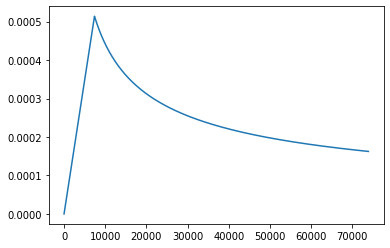

In [ ]:
plt.plot(list(map(lr_schedule, range(steps_per_epoch*20))))
plt.show()

# Loss Function and Optimizer

In [ ]:
loss_fn = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=CONFIG['ilr'], betas=CONFIG['betas'], eps=CONFIG['eps']
)

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_schedule)

scaler = torch.cuda.amp.GradScaler(enabled=CONFIG['use_amp'])

# Log model

In [ ]:
# from torch.utils.tensorboard import SummaryWriter

In [ ]:
# writer = SummaryWriter(run.dir+'/tensorboard_logs/imcap')

In [ ]:
# img, tgt = next(iter(train_loader))
# img = img.to(device)
# tgt = tgt.to(device)
# with torch.no_grad():
#     model(img, tgt)
# writer.add_graph(model, (img, tgt))
# writer.close()
# del img, tgt

In [ ]:
wandb.watch(model, log=None)

# Training functions

In [ ]:
from torch.cuda import amp

In [ ]:
def train_epoch(model, train_iter, optimizer, scaler, scheduler, epoch=1, use_amp=True, log_interval=10):
    model.train()
    model.encoder.eval()
    losses = 0
    with tqdm(enumerate(train_iter), total=len(train_iter), desc=f"Epoch {epoch}") as pbar:
        for idx, (img, tgt) in pbar:
            img = img.to(device)
            tgt = tgt.to(device)

            tgt_inp = tgt[:-1,:]      # give input until before the last word.
            tgt_out = tgt[1:, :]      # predict the last word based on input and already predicted sentence. (auto-regressive)

            tgt_mask, tgt_pad_mask = subsequent_mask(tgt_inp.size(0), device), padding_mask(tgt_inp, PAD_IDX)

            optimizer.zero_grad(set_to_none=True)
            with amp.autocast(enabled=use_amp):
                logits = model(img, tgt_inp, tgt_mask, tgt_pad_mask)
                loss = loss_fn(logits.reshape(-1, logits.size(-1)), tgt_out.reshape(-1))

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()

            losses+= loss.item()
            avg_loss = losses/(idx+1)
            curr_lr = optimizer.param_groups[0]['lr']
            info = {'loss': avg_loss, 'lr': curr_lr}

            if not idx%log_interval: wandb.log(info)
            pbar.set_postfix(info)

    optimizer.zero_grad(set_to_none=True)
    return losses/len(train_iter)

In [ ]:
def evaluate(model, val_iter, use_amp=True):
    model.eval()
    losses = 0
    with tqdm(enumerate(val_iter), total=len(val_iter), desc="Evaluating") as pbar:
        for idx, (img, tgt) in pbar:
            img = img.to(device)
            tgt = tgt.to(device)

            tgt_inp = tgt[:-1,:]      # give input until before the last word.
            tgt_out = tgt[1:, :]      # predict the last word based on input and already predicted sentence. (auto-regressive)

            tgt_mask, tgt_pad_mask = subsequent_mask(tgt_inp.size(0), device), padding_mask(tgt_inp, PAD_IDX)
            
            with amp.autocast(enabled=use_amp):
                logits = model(img, tgt_inp, tgt_mask, tgt_pad_mask)
                loss = loss_fn(logits.reshape(-1, logits.size(-1)), tgt_out.reshape(-1))

            losses+= loss.item()
            pbar.set_postfix({'val_loss': f"{losses/(idx+1):.3f}"})
    return losses/len(val_iter)

In [ ]:
# def save_model(model, optimizer, epoch):
#     torch.save({
#                 'model_state_dict': model.state_dict(),
#                 'optimizer_state_dict': optimizer.state_dict(),
#                 'epoch': epoch,
#                 }, run.dir + '/model.pth')

In [ ]:
init_epoch = 1

In [ ]:
NUM_EPOCHS = 50

In [ ]:
import gc
gc.collect()

918

# Begin Training

In [ ]:
#collapse-output
for epoch in range(init_epoch, NUM_EPOCHS+1):
    train_loss = train_epoch(model, train_loader, optimizer, scaler, scheduler,
                             epoch, CONFIG['use_amp'], CONFIG['log_interval'])
    gc.collect()
    with torch.no_grad():
        val_loss = evaluate(model, val_loader, CONFIG['use_amp'])
    wandb.log({"val_loss": val_loss, "epoch": epoch})
    print(f"Epoch: {epoch}/{NUM_EPOCHS}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}\n")
    # if not epoch%10:
    #     save_model(model, optimizer, epoch)


Epoch: 1/50, Train loss: 6.847, Val loss: 4.570



KeyboardInterrupt: ignored

In [ ]:
init_epoch = epoch

# Make Predictions

In [ ]:
def greedy_decode(model, img, max_len=100, start_symbol=BOS_IDX):
    model.eval()
    img = img.to(device)
    enc_output = model.encode_image(img)
    tgt = torch.ones(1, 1).fill_(start_symbol).long().to(device)
    for i in range(max_len):
        tgt_mask = subsequent_mask(tgt.size(0), device)
        out = model.decode_text(tgt, enc_output, tgt_mask)
        out = out.transpose(0,1)
        prob = model.generator(out[:,-1])
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.item()
        tgt = torch.cat([tgt, torch.ones(1, 1).fill_(next_word).long().to(device)], dim=0)
        if next_word == EOS_IDX:
            break
    return tgt

def generate_caption(model, img, tgt_vocab, tokenizer):
    with torch.no_grad():
        tgt = greedy_decode(model, img, max_len=100, start_symbol=BOS_IDX).flatten()
    return " ".join(tgt_vocab.lookup_tokens(tgt.tolist())).replace("<bos>", "").replace("<eos>", "")

In [ ]:
import os
import random

In [ ]:
paths = os.listdir("../datasets/COCO/val2017/")

In [ ]:
img = Image.open("../datasets/COCO/val2017/"+random.choice(paths))
img

In [ ]:
generate_caption(model, preproc['val'](img)[None,:], en_vocab, tokenizer)

' a plate of food with broccoli and vegetables . '